In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from plotting_utilities import *
import logging
from Test_Funcs import branin
%matplotlib inline

#  Regret Minimisation Plot (Sequential)

In [2]:
seed_size = 50
test_func = "branin"
save_file = False
estimator = "mean"

if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"

log_results = True
cumulative = True

In [3]:
def unpack_regret(func, dic):
    # Used to unpack X_hist values from gpyopt pickle dictionary to get Immediate Regret
    max_seed = max(dic.keys()) + 1 # how many seeds
    col_size = dic[0].shape[0] # how many iterations

    IR = np.zeros((max_seed, col_size))
    # Minimum y value
    min_y_dict = {
        "hartmann": np.array([-18.22368011]),
        "egg": np.array([-9.596407]),
        "branin": np.array([-14.96021125])
    }

    true_min_y = min_y_dict[func]

    for seed_i in range(max_seed):
        X_hist = dic[seed_i]
        Y_hist = branin(X_hist)

        if Y_hist.shape[0] == IR.shape[1]: # check whether matches, as gpyopt has errors
            IR[seed_i,:] = abs(Y_hist - true_min_y).flatten()
        else:
            print("Seed " + str(seed_i) + " has errors in data.")
            IR[seed_i,:] = np.zeros(IR.shape[1])

    IR = IR[~np.all(IR == 0, axis=1)] # remove rows with full zero (errors)
    IR = min_y_hist(IR)

    return IR

In [4]:
#####
# 1. Regret against number of iterations
#####
def gpyopt_regret(func, acq_func, seed_size = seed_size, batch_size = 1):

    X, min_y = load_pickle_gpyopt(func, seed_size, batch_size, acq_func, "local_penalization", False)
    IR = unpack_regret(func, X)
    
    """
    if batch_size > 1:
        IR = np.repeat(IR, repeats = batch_size * np.ones(IR.shape[1], dtype = int), axis = 1)
    """
    
    if cumulative:
        cumulative_regret = np.cumsum(IR, axis = 1) # turn IR into cumulative
        df = np_to_df(cumulative_regret)
    else:
        df = np_to_df(IR)
        
    if log_results == True: 
        df['values'] = np.log(df['values'])

    return df

def FITBO_regret(func, seed_size = seed_size, batch_size = 1):
    # Minimum y value
    min_y_dict = {
        "hartmann": np.array([-18.22368011]),
        "egg": np.array([-9.596407]),
        "branin": np.array([-14.96021125])
    }

    true_min_y = min_y_dict[func]
    
    y_hist = np.zeros((43,50))
    
    for seed_i in range(seed_size):
        y = load_pickle(seed_size, seed_i, func, False, "kb", 2, "Y")
        y_hist[:,seed_i] = y.flatten()
        
    y_hist = np.transpose(y_hist) # Produces array of size (seed_size, num_iters)
    y_hist = y_hist[:,2:] # Remove initial points
        
    IR = abs(y_hist - true_min_y)
    if cumulative:
        cumulative_regret = np.cumsum(IR, axis = 1) # turn IR into cumulative
        df = np_to_df(cumulative_regret)
    else:
        df = np_to_df(IR)

    if log_results == True: 
        df['values'] = np.log(df['values'])

    return df

def pso_regret(func, seed_size = seed_size, batch_size = 1):
    X_pso, min_y = load_pickle_pso(func, seed_size, batch_size)
    
    for seed_i in range(seed_size):
        X_pso[seed_i] = np.concatenate(X_pso[seed_i], axis=0 )
    
    IR = unpack_regret(func, X_pso)  
    
    if cumulative:
        cumulative_regret = np.cumsum(IR, axis = 1) # turn IR into cumulative
        df = np_to_df(cumulative_regret)
    else:
        df = np_to_df(IR)
        
    if log_results == True: 
        df['values'] = np.log(df['values'])

    return df

In [6]:
df_lcb = gpyopt_regret("branin", "LCB")
df_mpi = gpyopt_regret("branin", "MPI")
df_ei = gpyopt_regret("branin", "EI")

df_fitbo = FITBO_regret("branin")

df_pso = pso_regret("branin")

Seed 1 has errors in data.
Seed 10 has errors in data.
Seed 16 has errors in data.
Seed 33 has errors in data.
Seed 36 has errors in data.
Seed 48 has errors in data.
Seed 8 has errors in data.
Seed 14 has errors in data.
Seed 16 has errors in data.
Seed 22 has errors in data.
Seed 42 has errors in data.
Seed 10 has errors in data.
Seed 14 has errors in data.
Seed 16 has errors in data.
Seed 22 has errors in data.
Seed 36 has errors in data.
Seed 43 has errors in data.
Seed 48 has errors in data.


[Text(0, 0.5, 'Log Cumulative Simple Regret'),
 Text(0.5, 0, 'No. of Iterations'),
 Text(0.5, 1.0, 'Cumulative Simple Regret of Queries on Branin Function (mean, 50 seed)')]

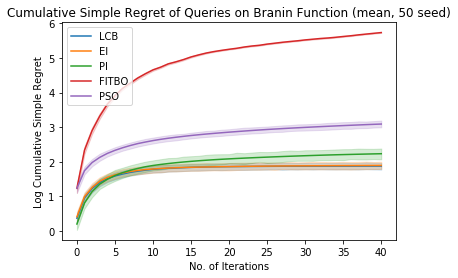

In [7]:
fig = sns.lineplot(x = 'iters', y = 'values', data = df_lcb, err_style = "band", \
                   label = "LCB", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_ei, err_style = "band", \
                   label = "EI", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_mpi, err_style = "band", \
                   label = "PI", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_fitbo, err_style = "band", \
                   label = "FITBO", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_pso, err_style = "band", \
                   label = "PSO", estimator = estimator, ci = 68)

graph_title = "Cumulative Simple Regret of Queries on Branin Function (mean, 50 seed)"
fig.set(xlabel = "No. of Iterations", ylabel = "Log Cumulative Simple Regret", title = graph_title)

## Simple Regret

In [8]:
seed_size = 50
test_func = "branin"
save_file = False
estimator = "mean"

if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"

log_results = False
cumulative = False

In [9]:
df_lcb = gpyopt_regret("branin", "LCB")
df_mpi = gpyopt_regret("branin", "MPI")
df_ei = gpyopt_regret("branin", "EI")

df_fitbo = FITBO_regret("branin")

df_pso = pso_regret("branin")

Seed 1 has errors in data.
Seed 10 has errors in data.
Seed 16 has errors in data.
Seed 33 has errors in data.
Seed 36 has errors in data.
Seed 48 has errors in data.
Seed 8 has errors in data.
Seed 14 has errors in data.
Seed 16 has errors in data.
Seed 22 has errors in data.
Seed 42 has errors in data.
Seed 10 has errors in data.
Seed 14 has errors in data.
Seed 16 has errors in data.
Seed 22 has errors in data.
Seed 36 has errors in data.
Seed 43 has errors in data.
Seed 48 has errors in data.


[Text(0, 0.5, 'Simple Regret'),
 Text(0.5, 0, 'No. of Iterations'),
 Text(0.5, 1.0, 'Simple Regret of Queries on Branin Function (mean, 50 seed)')]

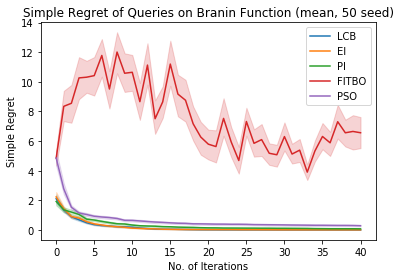

In [10]:
fig = sns.lineplot(x = 'iters', y = 'values', data = df_lcb, err_style = "band", \
                   label = "LCB", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_ei, err_style = "band", \
                   label = "EI", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_mpi, err_style = "band", \
                   label = "PI", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_fitbo, err_style = "band", \
                   label = "FITBO", estimator = estimator, ci = 68)
fig = sns.lineplot(x = 'iters', y = 'values', data = df_pso, err_style = "band", \
                   label = "PSO", estimator = estimator, ci = 68)

graph_title = "Simple Regret of Queries on Branin Function (mean, 50 seed)"
fig.set(xlabel = "No. of Iterations", ylabel = "Simple Regret", title = graph_title)